In [118]:
# Learning Resources:
#  - https://www.pythonguis.com/tutorials/tkinter-basic-widgets/
#  - https://www.tcl-lang.org/man/tcl8.6/TkCmd/contents.htm
#  - https://www.tutorialspoint.com/python/python_gui_programming.htm
#  - https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html#

# Theme found at:
# - https://github.com/rdbende/Sun-Valley-ttk-theme

In [119]:
import tkinter as tk
from tkinter import ttk
from ttkthemes import ThemedTk
import sv_ttk
import yfinance as yf
import pandas as pd
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import date
from dateutil.relativedelta import relativedelta

In [120]:
class guiWindow:
    def __init__(self):
        # try breeze dark theme
        # self.root = ThemedTk(theme="breezedark")
        # or try this theme?
        self.root = tk.Tk()
        sv_ttk.set_theme("dark")
        # ----------------------
        self.frames={}
        self.stock_data = {}
        self.stock_tickers = []
        self.main_visuals = {"line_charts": {},
                             "finance_tables": {},
                             "metrics_tables": {},
                             "recommendations_tables": {},
                             }
        self.current_main_frame_name = None # Chart object
        self.current_main_key = None # Chart string/key
        self.current_tab = "chart"
        self.current_frames = {}

        # Additional configuration
        self.root.title("stockr")
        self.root.minsize(255,330)
        self.root.maxsize(2550,3300)
        self.root.geometry("1200x800")
        # self.root.configure(background='lightgrey')

In [121]:
class guiVisuals:
    def __init__(self, guiWindow, type:str, ticker:str, target_frame, tab_name=None):
        self.guiWindow = guiWindow
        self.type = type.lower()
        self.ticker = ticker
        if target_frame is not None and target_frame in guiWindow.frames:
            self.target_frame = guiWindow.frames[target_frame]
        else:
            self.target_frame = guiWindow.root
        self.tab_name = tab_name
        self.stock_data = guiWindow.stock_data[f"{ticker}_data"]
        # self.stock_data.reset_index(inplace=True)
        self.dispatch_type()
    
    def dispatch_type(self):
        # Redirect type parameter to visual call
        method_name = f"create_{self.type}"
        method = getattr(self, method_name, None)
        if method:
            method()
        else:
            print(f"[Warning]: Visuals visual type '{self.type}' not yet implemented.")

    def create_finance_table(self):
        self.frame_name = f"{self.ticker}_financials_frame"
        container = tk.Frame(self.target_frame, bg="#1e1e1e")
        self.guiWindow.frames[self.frame_name] = container

        style = ttk.Style()
        style.configure("Dark.Treeview",
                        background="#2b2b2b",
                        foreground="#ffffff",
                        fieldbackground="#2b2b2b",
                        font=("Helvetica", 10),
                        rowheight=24)
        style.configure("Dark.Treeview.Heading",
                        background="#333333",
                        foreground="#ffffff",
                        font=("Helvetica", 10, "bold"))
        style.map("Dark.Treeview",
                background=[("selected", "#444444")])

        self.stock_data = self.stock_data.drop(columns=["level_0", "index"], errors="ignore")

        tree = ttk.Treeview(container, style="Dark.Treeview")
        tree["columns"] = list(self.stock_data.columns)
        tree["show"] = "headings"

        tree.tag_configure("evenrow", background="#2b2b2b")
        tree.tag_configure("oddrow", background="#252525")

        for col in self.stock_data.columns:
            width = max(80, min(150, int(self.stock_data[col].astype(str).map(len).mean() * 7)))
            tree.column(col, anchor="center", width=width)
            tree.heading(col, text=col)

        for i, (_, row) in enumerate(self.stock_data.iterrows()):
            tag = "evenrow" if i % 2 == 0 else "oddrow"
            tree.insert("", "end", values=list(row), tags=(tag,))

        tree.pack(fill="both", expand=True, padx=2, pady=2)

        self.guiWindow.main_visuals["finance_tables"][self.ticker] = self.frame_name

    def create_line_chart(self):
        self.frame_name = f"{self.ticker}_line_chart_frame"
        container = tk.Frame(self.target_frame)
        self.guiWindow.frames[self.frame_name] = container

        df = self.stock_data.copy()
        df["Average Price"] = (df["High"] + df["Low"]) / 2

        with plt.style.context("dark_background"):
            fig, ax = plt.subplots(figsize=(8, 4))

            deep_gray = "#1e1e1e"   
            fig.patch.set_facecolor(deep_gray)   
            ax.set_facecolor(deep_gray)          

            ax.plot(
                df["Date"],
                df["Average Price"],
                label="Average Price",
                color="deepskyblue",
                linewidth=1.5,
                marker="o" if len(df) <= 62 else None,
            )

            ax.set_ylabel("Average Price (USD)", color="white")
            ax.tick_params(axis="both", labelsize=8, colors="white")
            ax.spines["bottom"].set_color("white")
            ax.spines["left"].set_color("white")
            ax.grid(True, color="#444", linestyle="--", linewidth=0.5)

            fig.tight_layout(pad=1.0)     
            fig.subplots_adjust(top=0.95, bottom=0.15, left=0.10, right=0.98)

            fig.autofmt_xdate(rotation=30)
            ax.xaxis.set_major_locator(plt.MaxNLocator(10))
            ax.yaxis.set_major_locator(plt.MaxNLocator(8))

            canvas = FigureCanvasTkAgg(fig, master=container)
            canvas.draw()
            canvas.get_tk_widget().pack(fill="both", expand=True)

        self.guiWindow.main_visuals["line_charts"][self.ticker] = self.frame_name


    def create_metrics_table(self):
        self.frame_name = f"{self.ticker}_metrics_frame"
        container = tk.Frame(self.target_frame, bg="#1e1e1e")
        self.guiWindow.frames[self.frame_name] = container

        ticker_ref = yf.Ticker(self.ticker)
        metrics_list = {
            "52 Week Range": ticker_ref.info.get("fiftyTwoWeekRange"),
            "Forward PE": ticker_ref.info.get("forwardPE"),
            "Trailing PE": ticker_ref.info.get("trailingPE"),
            "Profit Margins": ticker_ref.info.get("profitMargins"),
            "Gross Profits": ticker_ref.info.get("grossProfits"),
            "Free Cashflow": ticker_ref.info.get("freeCashflow"),
            "Debt to Equity": ticker_ref.info.get("debtToEquity"),
            "Beta": ticker_ref.info.get("beta"),
        }

        df = pd.DataFrame(list(metrics_list.items()), columns=["Metric", "Value"])

        style = ttk.Style()
        style.configure(
            "Metrics.Treeview",
            background="#1e1e1e",    
            fieldbackground="#1e1e1e",
            foreground="white",   
            rowheight=24,
            borderwidth=0,
            font=("Segoe UI", 11),
        )
        style.configure(
            "Metrics.Treeview.Heading",
            background="#2b2b2b", 
            foreground="white",
            relief="flat",
            font=("Segoe UI", 12, "bold")
        )
        style.map(
            "Metrics.Treeview",
            background=[("selected", "#3a6ea5")],
            foreground=[("selected", "white")]
        )

        tree = ttk.Treeview(container, style="Metrics.Treeview", show="headings")
        tree["columns"] = list(df.columns)

        tree.tag_configure("evenrow", background="#252525")
        tree.tag_configure("oddrow", background="#1e1e1e")

        for col in df.columns:
            width = max(120, int(df[col].astype(str).map(len).mean() * 9))
            tree.column(col, anchor="w", width=width)
            tree.heading(col, text=col)

        for i, (_, row) in enumerate(df.iterrows()):
            tag = "evenrow" if i % 2 == 0 else "oddrow"
            tree.insert("", "end", values=list(row), tags=(tag,))

        tree.pack(fill="both", expand=True, padx=5, pady=5)

        self.guiWindow.main_visuals["metrics_tables"][self.ticker] = self.frame_name

    def create_recommendations_table(self):
        self.frame_name = f"{self.ticker}_recommendations_frame"
        container = tk.Frame(self.target_frame, bg="#1e1e1e")
        self.guiWindow.frames[self.frame_name] = container

        ticker_ref = yf.Ticker(self.ticker)
        recs = ticker_ref.get_recommendations_summary()
        recs_buy = recs.iloc[0]["strongBuy"] + recs.iloc[0]["buy"]
        recs_hold = recs.iloc[0]["hold"]
        recs_sell = recs.iloc[0]["sell"] + recs.iloc[0]["strongSell"]
        recs_list = {
            "Mean Analyst Price Target": ticker_ref.analyst_price_targets["mean"],
            "No. Buy Recommendations": recs_buy,
            "No. Hold Recommendations": recs_hold,
            "No. Sell Recommendations": recs_sell
        }

        df = pd.DataFrame(list(recs_list.items()), columns=["Metric", "Value"])

        style = ttk.Style()
        style.configure("Dark.Treeview",
                        background="#2b2b2b",
                        foreground="#ffffff",
                        fieldbackground="#2b2b2b",
                        font=("Helvetica", 11),
                        rowheight=24)
        style.configure("Dark.Treeview.Heading",
                        background="#333333",
                        foreground="#ffffff",
                        font=("Helvetica", 12, "bold"))
        style.map("Dark.Treeview",
                background=[("selected", "#444444")])

        tree = ttk.Treeview(container, style="Dark.Treeview")
        tree["columns"] = list(df.columns)
        tree["show"] = "headings"

        tree.tag_configure("evenrow", background="#2b2b2b")
        tree.tag_configure("oddrow", background="#252525")

        for col in df.columns:
            width = max(120, int(df[col].astype(str).map(len).mean() * 10))
            tree.column(col, anchor="w", width=width)
            tree.heading(col, text=col)

        for i, (_, row) in enumerate(df.iterrows()):
            tag = "evenrow" if i % 2 == 0 else "oddrow"
            tree.insert("", "end", values=list(row), tags=(tag,))

        tree.pack(fill="both", expand=True, padx=2, pady=2)

        self.guiWindow.main_visuals["recommendations_tables"][self.ticker] = self.frame_name


In [122]:
class guiInteractables:
    def __init__(self, guiWindow, type, target_frame, padx=None, pady=None, side=None, 
                 fill=None, entry_text=None, on_submit=None,function=None):
        self.guiWindow = guiWindow
        self.type = type.lower()
        if target_frame is not None and target_frame in guiWindow.frames:
            self.target_frame = guiWindow.frames[target_frame]
        else:
            self.target_frame = guiWindow.root
        self.padx = padx
        self.pady = pady
        self.side = side
        self.fill = fill
        self.entry_text = entry_text if entry_text else "You forgot input text!"

        self.on_submit = on_submit
        self.function = function    # per widget
        
        self.dispatch_type()

    def dispatch_type(self):
        method_name = f"create_{self.type}"
        method = getattr(self, method_name, None)
        if method:
            method()
        else:
            print(f"[Warning]: Interactable visual type '{self.type}' not yet implemented.")
    
    def handle_submit(self, event=None):
        value = self.entry.get()
        if callable(self.function):
            self.function(value)
        if callable(self.on_submit):
            self.on_submit(value)
        self.entry.delete(0, tk.END)
    
    def handle_combobox_submit(self, event=None):
        value = self.combobox.get()
        if callable(self.function):
            self.function(value)
        if callable(self.on_submit):
            self.on_submit(value)
# ----------------------------------------------------------------------------------------------------------
    def create_entry(self):
        self.entry = tk.Entry(self.target_frame, width=30)
        self.entry.insert(0, string=self.entry_text)
        self.entry.bind("<Return>", self.handle_submit)
        self.entry.pack(padx=self.padx, pady=self.pady, side=self.side, fill=self.fill)
        return self.entry
# ----------------------------------------------------------------------------------------------------------
    def create_combobox(self):
        self.combo_var = tk.StringVar()
        self.combobox = ttk.Combobox(self.target_frame, textvariable=self.combo_var, state="readonly", width=30)
        self.combobox['values'] = self.guiWindow.stock_tickers
        self.combobox.bind("<<ComboboxSelected>>", self.handle_combobox_submit)
        self.combobox.set(self.entry_text)
        self.combobox.pack(padx=self.padx, pady=self.pady, side=self.side, fill=self.fill)
        return self.combobox

In [123]:
class guiFrames:
    def __init__(self, guiWindow, frame_name, width=800, height=600,
                 parent_frame=None, use_place=False,
                 relx=None, rely=None, anchor=None, x=None, y=None,
                 padx=None, pady=None, side=None, fill=None, bg="gray25"):
        self.guiWindow = guiWindow
        self.frame_name = frame_name
        self.width = width
        self.height = height
        self.parent_frame = parent_frame
        self.use_place = use_place
        self.bg = bg
        self.placement = dict(relx=relx, rely=rely, anchor=anchor, x=x, y=y,
                              padx=padx, pady=pady, side=side, fill=fill)

        self.create_frame()

    def create_frame(self):
        parent = self.guiWindow.frames.get(self.parent_frame, self.guiWindow.root)

        bg = self.bg if parent != self.guiWindow.root else "gray25"

        self.frame = tk.Frame(parent, bg=bg, width=self.width, height=self.height)
        self.frame.pack_propagate(False)

        # experimental... revisit logic
        if self.use_place and self.placement["relx"] is not None and self.placement["rely"] is not None:
            placement_args = {k: v for k, v in self.placement.items() if v is not None}
            self.frame.place(**placement_args)
        else:
            self.frame.pack(anchor="center")

        self.guiWindow.frames[self.frame_name] = self.frame
        return self.frame

In [124]:
class dataOperations:
    def __init__(self, guiWindow, ticker=None, start_date=None, end_date=None, interval="1d"):
        self.ticker = ticker
        today = date.today()
        self.start_date = start_date if start_date is not None else today - relativedelta(months=6)
        self.end_date = end_date if end_date is not None else today
        self.end_date = today
        self.interval = interval if interval is not None else "60m"
        self.stock_data = guiWindow.stock_data

    def fetch_stock_data(self):
        """
        Note: plucked from old project, modified as needed.
        """
        data = yf.download(
            self.ticker, start=self.start_date, end=self.end_date, interval=self.interval, rounding=True)
        # storing financials 
        self.stock_data[f"{self.ticker}_data"] = data
        # running list of tickers found in stock_data["tickers"]
        if "tickers" not in self.stock_data:
            self.stock_data["tickers"] = []
        if self.ticker not in self.stock_data["tickers"]:
            self.stock_data["tickers"].append(self.ticker)

        guiWindow.stock_data = self.stock_data  # Update the stock_data in guiWindow
        return self.stock_data
    
    def correct_stock_data(self):
        """
        Clean and standardize stock data:
        - Flattens multi-index if needed
        - Renames the index column to 'Date'
        - Formats date to exclude seconds
        - Drops time entirely if it's midnight (daily interval)
        """
        ticker_key = f"{self.ticker}_data"
        df = self.stock_data[ticker_key]

        if isinstance(df.columns, pd.MultiIndex):
            df = df.droplevel("Ticker", axis=1)

        df = df.reset_index()
        df.rename(columns={df.columns[0]: "Date"}, inplace=True)

        # Format 'Date' column depending on time presence
        if pd.api.types.is_datetime64_any_dtype(df["Date"]):
            if (df["Date"].dt.time == pd.Timestamp("00:00").time()).all():
                df["Date"] = df["Date"].dt.strftime('%Y-%m-%d')  # Drop time if it's all midnight (daily/monthly data)
            else:
                df["Date"] = df["Date"].dt.strftime('%Y-%m-%d %H:%M')  # Keep hours + minutes

        df.columns.name = "Data Index"
        self.stock_data[ticker_key] = df

        return self.stock_data

In [125]:
# Functions used by interactables
    # Stock selection & data generation --------------------------------------------------------------------------------
def add_ticker(value):
    ticker = (value or "").strip().upper()
    if not (ticker and 1 <= len(ticker) <= 6):
        return

    if ticker in window.stock_tickers:
        # already exists, just show it
        show_visual_for_ticker("finance_tables", ticker)
        show_visual_for_ticker("line_charts", ticker)
        return
    
    window.stock_tickers.insert(0, ticker)
    stock_history_widget.combobox['values'] = window.stock_tickers

    ops = dataOperations(guiWindow=window, ticker=ticker)
    ops.fetch_stock_data()
    ops.correct_stock_data()

    ensure_visual_for_tab("line_charts", ticker)
    ensure_visual_for_tab("finance_tables", ticker)
    
    # Load supplementary table
    if ticker not in window.main_visuals.get("metrics_tables", {}):
        guiVisuals(window, type="metrics_table", ticker=ticker, target_frame="main_supplementary_frame")
        metrics_frame_name = f"{ticker}_metrics_frame"
        metrics_table = window.frames[metrics_frame_name]
        metrics_table.place(in_=window.frames["main_supplementary_frame"],
                            relx=0, rely=0, relwidth=1, relheight=1)
        window.current_frames["metrics_tables"] = metrics_frame_name

    # Load recommendations table
    if ticker not in window.main_visuals.get("recommendations_tables", {}):
        guiVisuals(window, type="recommendations_table", ticker=ticker, target_frame="main_recommendations_frame")
        rec_frame_name = f"{ticker}_recommendations_frame"
        recommendations_table = window.frames[rec_frame_name]
        recommendations_table.place(in_=window.frames["main_recommendations_frame"],
                                    relx=0, rely=0, relwidth=1, relheight=1)
        window.current_frames["recommendations_tables"] = rec_frame_name

    show_visual_for_ticker("finance_tables", ticker)
    show_visual_for_ticker("line_charts", ticker)

    # Stock history
def switch_ticker(value):
    ticker = (value or "").strip().upper()
    if not ticker:
        return

    # Static visuals
    switch_static_visual("metrics_tables", "main_supplementary_frame", ticker)
    switch_static_visual("recommendations_tables", "main_recommendations_frame", ticker)

    # Notebook visuals - line chart last to set as the default visual loaded
    ensure_visual_for_tab("line_charts", ticker)
    ensure_visual_for_tab("finance_tables", ticker)
    show_visual_for_ticker("finance_tables", ticker)
    show_visual_for_ticker("line_charts", ticker)

def switch_static_visual(visual_type: str, parent_name: str, ticker: str):
    new_name = window.main_visuals.get(visual_type, {}).get(ticker)
    if not new_name:
        return

    prev_name = window.current_frames.get(visual_type)
    if prev_name and prev_name != new_name:
        prev_frame = window.frames.get(prev_name)
        if prev_frame:
            prev_frame.place_forget()

    new_frame = window.frames.get(new_name)
    if new_frame:
        new_frame.place(in_=window.frames[parent_name],
                        relx=0, rely=0, relwidth=1, relheight=1)
        window.current_frames[visual_type] = new_name

    # Data display ------------------------------------------------------------------------------------------
def ensure_visual_for_tab(visual_type: str, ticker: str):
    ticker = (ticker or "").strip().upper()
    if not ticker:
        return None

    if ticker in window.main_visuals.get(visual_type, {}):
        return window.main_visuals[visual_type][ticker]

    # create visual
    if visual_type == "line_charts":
        guiVisuals(window, type="line_chart", ticker=ticker, target_frame="chart_tab", tab_name="chart")
    elif visual_type == "finance_tables":
        guiVisuals(window, type="finance_table", ticker=ticker, target_frame="financials_tab", tab_name="financials")
    else:
        return None

    return window.main_visuals.get(visual_type, {}).get(ticker)

def show_visual_for_ticker(visual_type: str, ticker: str) -> bool:
    ticker = (ticker or "").strip().upper()
    if not ticker:
        return False

    frame_name = window.main_visuals.get(visual_type, {}).get(ticker)
    if not frame_name:
        return False

    frame_obj = window.frames.get(frame_name)
    if not frame_obj:
        return False

    prev_frame_name = window.current_frames.get(visual_type)
    if prev_frame_name and prev_frame_name != frame_name:
        prev_frame = window.frames.get(prev_frame_name)
        prev_frame.place_forget()

    if visual_type == "line_charts":
        parent_tab = window.frames.get("chart_tab")
    elif visual_type == "finance_tables":
        parent_tab = window.frames.get("financials_tab")
    else:
        return False

    frame_obj.place(in_=parent_tab, relx=0, rely=0, relwidth=1, relheight=1)

    window.current_frames[visual_type] = frame_name
    window.current_main_frame_name = frame_name     
    window.current_main_key = ticker
    window.current_tab = visual_type

    stock_history_widget.combobox.set(ticker)

    return True

/var/folders/yt/068k7p4x3934d27j929_47ww0000gn/T/ipykernel_6637/2944487407.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed
/var/folders/yt/068k7p4x3934d27j929_47ww0000gn/T/ipykernel_6637/2944487407.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed


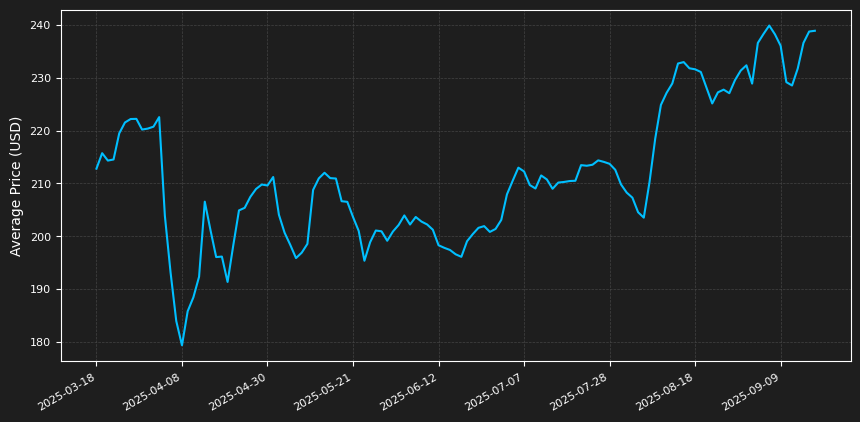

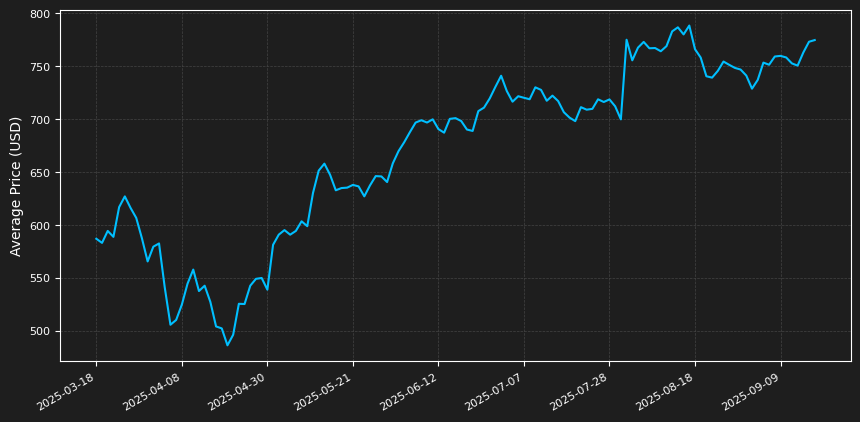

In [126]:
window = guiWindow()
# ----------------------------------------------------------------------------------------------------------
# Frame Setup
        # Parent frames -> sum = 1135 (old)
main_notebook_frame = guiFrames(window, "main_notebook_frame", width=900, height=510, 
                                use_place=True, relx=1, rely=0, anchor='ne', x=-10, y=20)
main_toggle_frame = guiFrames(window, "main_toggle_frame", width=260, height=500, 
                              use_place=True, relx=0, rely=0, anchor='nw', x=20, y=20)
main_supplementary_frame = guiFrames(window, "main_supplementary_frame",width=740, height = 240, 
                                    use_place = True, relx=0, rely=1, x=20, y=-20, anchor='sw')
main_recommendations_frame = guiFrames(window, "main_recommendations_frame", width=395, height=240,
                            use_place=True, relx=1, rely=1, x=-20, y=-20, anchor='se')
        # Nested frames
toggle_frame = guiFrames(window, "toggle_frame", width=250, height=490, 
                         parent_frame=main_toggle_frame.frame_name, use_place=True,
                        anchor='center', relx=0.5, rely=0.5, bg='gray25')
        # Notebook creation for main_frame
notebook = ttk.Notebook(window.frames['main_notebook_frame'])
notebook.pack(fill="both", expand=True)
chart_tab = ttk.Frame(notebook)
financials_tab = ttk.Frame(notebook)
# add further tabs?
notebook.add(chart_tab, text="Chart")
notebook.add(financials_tab, text="Financials")
window.frames['main_notebook'] = notebook
window.frames['chart_tab'] = chart_tab
window.frames['financials_tab'] = financials_tab
# ----------------------------------------------------------------------------------------------------------
# Interactables setup
stock_history_widget = guiInteractables(
    window, type="combobox", target_frame=toggle_frame.frame_name, padx=10, pady=10, side="top", fill="x", 
    entry_text="Select from History", function=switch_ticker, on_submit=None)

stock_selection_widget = guiInteractables(
    window, type="entry", target_frame=toggle_frame.frame_name, padx=10, pady=10, side="top", fill="x", 
    entry_text="Input (e.g. AAPL)", function=add_ticker, on_submit=None)
# ----------------------------------------------------------------------------------------------------------
# Run main loop
window.root.mainloop()